# Garbage Classification

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -q kaggle

kaggle_creds_path = "/content/drive/MyDrive/Computer Vision/kaggle.json"

!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Computer Vision/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download "mostafaabla/garbage-classification"

!unzip -q garbage-classification.zip -d "garbage-classification"

100% 239M/239M [00:12<00:00, 24.1MB/s]
100% 239M/239M [00:12<00:00, 20.2MB/s]


# Import Required Libraries

In [3]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print('setup successful!')

setup successful!


# Define Constants

In [4]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
base_path = "./garbage-classification/garbage_classification/"

# Dictionary to save our 12 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'green-glass', 9: 'brown-glass', 10: 'white-glass',
              11: 'biological'}

print('defining constants successful!')

defining constants successful!


# Create DataFrame

In [5]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])

    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  15515


In [6]:
df.head()

,filename,category
0,clothes/clothes1245.jpg,7
1,brown-glass/brown-glass70.jpg,9
2,clothes/clothes26.jpg,7
3,brown-glass/brown-glass31.jpg,9
4,clothes/clothes1742.jpg,7


shoes/shoes656.jpg


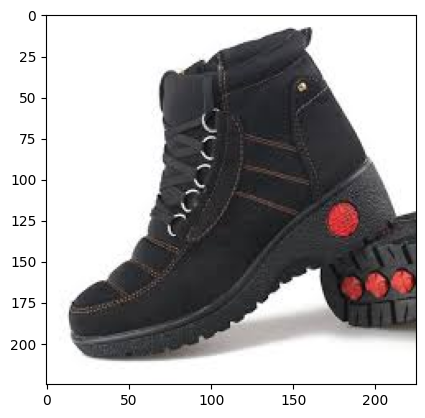

In [7]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path +sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

# Viusalize the Categories Distribution

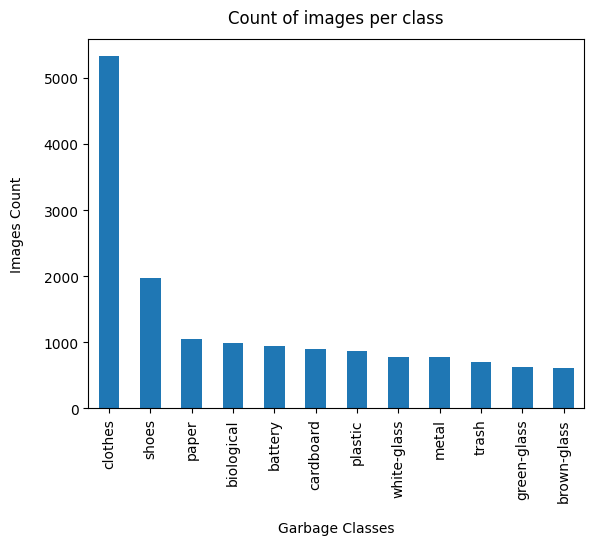

In [8]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

# Create the model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.optimizers import Adam

# Assuming you have defined IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS, and categories

# Create MobileNetV2 model without pre-trained weights
base_model = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))


model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

52606240/52606240 [==============================] - 3s 0us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 12)                18444     
                                                                 
Total params: 12949066 (49.40 MB)
Trainable params: 18444 (72.05 KB)
Non-trainable params: 12930622 (49.33 MB)
_________________________________________________________________


# Split the Data Set

In [10]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories)

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_validate , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  1551 validate size =  1551 test size =  1552


# Train the model

In [11]:
batch_size=64

train_datagen = image.ImageDataGenerator(

    ###  Augmentation Start  ###

    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2

    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 12 classes.


In [12]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 12 classes.


In [13]:
EPOCHS = 5
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
)

<ipython-input-13-6f8413f2548b>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
193/193 [==============================] - 74s 280ms/step - loss: 0.5537 - accuracy: 0.8702 - val_loss: 0.2494 - val_accuracy: 0.9408
Epoch 2/5
193/193 [==============================] - 42s 216ms/step - loss: 0.2120 - accuracy: 0.9453 - val_loss: 0.1905 - val_accuracy: 0.9499
Epoch 3/5
193/193 [==============================] - 41s 214ms/step - loss: 0.1595 - accuracy: 0.9579 - val_loss: 0.1693 - val_accuracy: 0.9544
Epoch 4/5
193/193 [==============================] - 41s 213ms/step - loss: 0.1389 - accuracy: 0.9602 - val_loss: 0.1581 - val_accuracy: 0.9557
Epoch 5/5
193/193 [==============================] - 44s 226ms/step - loss: 0.1258 - accuracy: 0.9630 - val_loss: 0.1566 - val_accuracy: 0.9564


In [ ]:
model.save_weights("model.h5")

# Visualize the training process


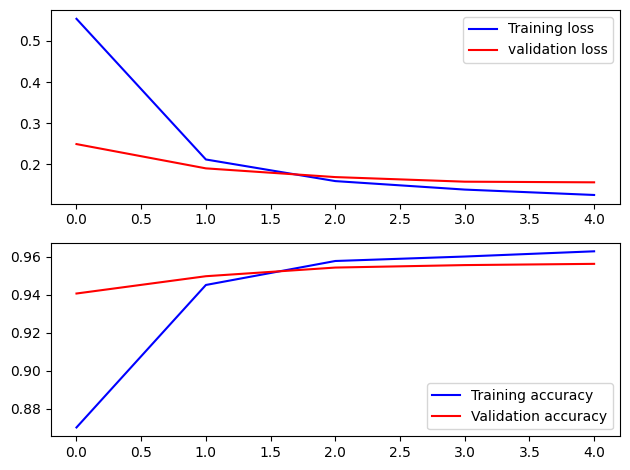

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
# ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Evaluate the test

In [15]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False
)

Found 1552 validated image filenames belonging to 12 classes.


In [16]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

<ipython-input-16-dccc2276ab82>:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


accuracy on test set =  96.33 % 


In [17]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}


In [18]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

<ipython-input-18-a783aa827507>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.98      0.97      0.97        97
  biological       0.97      1.00      0.98       111
 brown-glass       0.95      0.93      0.94        68
   cardboard       0.93      0.95      0.94        78
     clothes       1.00      0.99      1.00       575
 green-glass       0.89      0.93      0.91        54
       metal       0.87      0.86      0.86        77
       paper       0.95      0.93      0.94        99
     plastic       0.91      0.91      0.91        81
       shoes       0.97      0.99      0.98       175
       trash       0.98      0.98      0.98        66
 white-glass       0.90      0.87      0.89        71

    accuracy                           0.96      1552
   macro avg       0.94      0.94      0.94      1552
weighted avg       0.96      0.96      0.96      1552



### SAVING THE MODEL AND CONVERTING TO TENSORFLOW LITE

In [19]:
# save the model
model.save('garbage_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# convert to tensorflow lite
loaded_model = tf.keras.models.load_model('/kaggle/working/garbage_classifier')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('/kaggle/working/garbage_classifer.tflite', 'wb') as f:
    f.write(tflite_model)

OSError: No file or directory found at /kaggle/working/garbage_classifier

Predict a single image

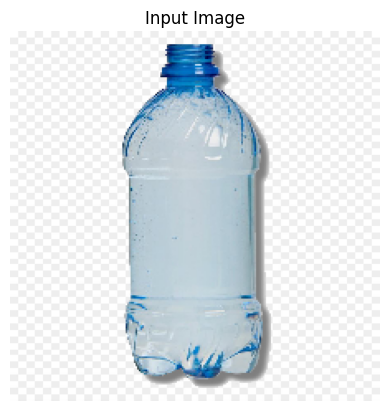

In [20]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

# Load and preprocess the input image
img_path = '/content/kisspng-plastic-bottle-polyethylene-terephthalate-water-bo-5ae04f33df6765.6098791315246497799151.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust the target size according to your model's input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Display the image
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model('garbage_classifier.h5')

In [21]:
# Make predictions
predictions = model.predict(img_array)

# Define your class labels
classes = {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 5: 'green-glass', 6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash', 11: 'white-glass'}

# Get the predicted class index
predicted_class_index = predictions.argmax(axis=1)[0]

# Get the predicted class label
predicted_class_label = classes[predicted_class_index]


print(predictions)
# Print the predicted class and its corresponding label
print(f'Predicted Class Index: {predicted_class_index}')
print(f'Predicted Class Label: {predicted_class_label}')

1/1 [==============================] - 3s 3s/step
[[0.13838151 0.01015447 0.15039866 0.03655861 0.01205859 0.1579487
  0.01840648 0.02226863 0.15689836 0.04341935 0.09547219 0.15803446]]
Predicted Class Index: 11
Predicted Class Label: white-glass


In [ ]:
loaded_model = tf.keras.models.load_model('garbage_classifier.keras', safe_mode=False)

In [23]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 82.3 MB/s eta 0:00:00


In [24]:
import tensorflowjs as tfjs

In [ ]:
tfjs.converters.save_keras_model(model, 'tfjs_model')

In [25]:
!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model /content/garbage_classifier.h5 /content/tfjs_model/

2024-02-17 23:55:26.636994: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 23:55:26.637047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 23:55:26.638992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 23:55:29.091577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-17 23:55:33.581471: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [ ]:
!rm -r tfjs_model/

In [26]:
!zip -r model.zip tfjs_model/

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard10of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard11of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard12of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of13.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 96%)
  adding: tfjs_model/group1-shard7of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard13of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of13.bin (deflated 8%)
  adding: tfjs_model/group1-shard8of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard5of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard9of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard4of13.bin (deflated 7%)
  adding: tfjs_model/group1-shard6of13.bin (deflated 7%)
